In [ ]:
from scipy.ndimage import label
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
print(torch.__version__, torchvision.__version__)

from skimage.feature import peak_local_max

def load_scores(rootdir):
  '''
  load the model evaluation results into array
  '''
  numel = []
  mael = []
  dcel = []
  recalll = []
  precisionl = []
  posd = []
  coords = []
  for file in sorted(os.listdir(rootdir)):

    if file[0]!='S':
      continue

    print(file)
    result = np.load(rootdir + file, allow_pickle=True)
    numel.append(result['nume'])
    mael.append(result['mae'])
    dcel.append(result['dce'])
    recalll.append(result['recall'])
    precisionl.append(result['precision'])
    posd.append(result['deviations'])
    coords.append(result['coordinates'])
  repeat = numel[0].shape[1]
  size = len(numel)*10
  numel = np.asarray(numel).reshape((size,repeat))
  mael = np.asarray(mael).reshape((size,repeat))
  dcel = np.asarray(dcel).reshape((size,repeat))
  recalll = np.asarray(recalll).reshape((size,repeat))
  precisionl = np.asarray(precisionl).reshape((size,repeat))
  posd = np.asarray(posd).reshape((size,repeat))
  coords = np.asarray(coords).reshape((size,repeat))

  return (numel, mael, dcel, recalll, precisionl, posd, coords)

  def load_pos_event(rootdir):
  # result with eventsize saved, posd is not thresholded. You need to do that after loaded.
  numel = []
  posd = []
  eventsize = []
  for file in sorted(os.listdir(rootdir)):

    if file[0]!='S':
      continue

    print(file)
    result = np.load(rootdir + file, allow_pickle=True)
    numel.append(result['nume'])
    posd.append(result['deviations'])
    eventsize.append(result['eventsizes'])

  repeat = numel[0].shape[1]
  size = len(numel)*10
  numel = np.asarray(numel).reshape((size,repeat))
  posd = np.asarray(posd).reshape((size,repeat))
  eventsize = np.asarray(eventsize).reshape((size,repeat))


  return (numel, posd, eventsize)

2.0.1+cu118 0.15.2+cu118


In [ ]:
def r_p_cal(dcearray, posdarray):
  '''
  Calculate R and P based on position deviation. The definition of truth positive is within 1-px neighborhood of ground truth position.
  '''
  tolerance = 1
  precision = np.zeros(dcearray.shape)
  recall = np.zeros(dcearray.shape)
  f1 = np.zeros(dcearray.shape)
  for i in range(dcearray.shape[0]):
    for j in range(dcearray.shape[1]):
      tp= np.where(posdarray[i,j]<=tolerance)[0].shape[0]
      precision[i,j] = tp/posdarray[i,j].shape[0]
      recall[i,j] = precision[i,j]*dcearray[i,j]
      f1[i,j] = 2*((precision[i,j] *recall[i,j])/(precision[i,j] + recall[i,j]))
  return recall, precision, f1

In [ ]:
numel,_,dce_rcnn_max,r_rcnn_max,p_rcnn_max, posd_rcnn_max,_ =  load_scores('/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/ValidationResults/nnmax_locatecorrected/')
# change the path to where you saved the model evaluation results files.

# Position deviation

In [ ]:
total = []
for (x, y), element in np.ndenumerate(posd_rcnn_max[:]):
  element = [x for x in element if x <= 6]
  total = total + element

In [ ]:
y = np.array(total)
plt.boxplot([y],  showfliers=False, labels = ['DL'], showmeans=True)
plt.set_ylabel('Position deviation (px)')
plt.set_ylim(-0.1,3.5)

#Recall, Precision, F1

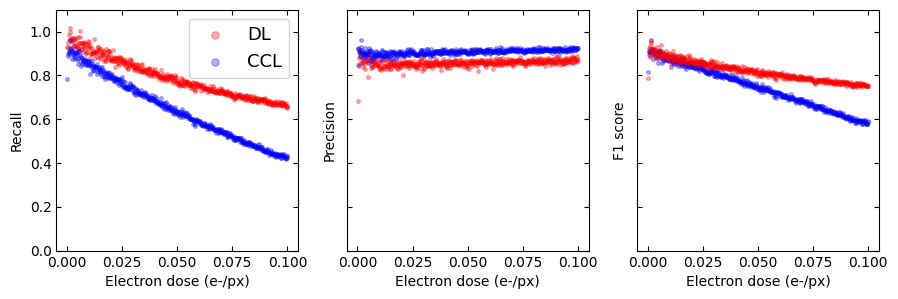

In [ ]:
fig, ax = plt.subplots(figsize=(9, 3), nrows=1, ncols=3)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2,hspace=0.3)
###################################################
rdl, pdl, fdl = r_p_cal(dce_rcnn_max, posd_rcnn_max)
# rcca, pcca, fcca = r_p_cal(dce_cca, posd_cca)
# The total pixel is 256x256=65536

ax[0].scatter(numel[:,0]/65536,rdl[:,0],  label = 'DL', s= 7, c = 'r', alpha = 0.3)
# ax[0].scatter(numel[:,0]/65536,rcca[:,0],  label = 'CCL', s= 7, c = 'b', alpha = 0.3)
ax[0].set_ylim((0,1.1))
ax[0].set_ylabel('Recall')
#ax[0].set_title('Recall')

ax[0].legend(markerscale = 2, fontsize = 13)
ax[0].tick_params(right = True, top = True, direction = 'in')
ax[0].set_xlabel('Electron dose (e\u002d/px)')

ax[1].scatter(numel[:,0]/65536,pdl[:,0],  label = 'DL',s= 7, c = 'r', alpha = 0.3)
# ax[1].scatter(numel[:,0]/65536,pcca[:,0],  label = 'CCA',s= 7, c = 'b', alpha = 0.3)
ax[1].set_ylim((0,1.1))
ax[1].set_ylabel('Precision')
ax[1].tick_params(right = True, top = True, direction = 'in')
ax[1].set_yticklabels([])
ax[1].set_xlabel('Electron dose (e\u002d/px)')

ax[2].scatter(numel[:,0]/65536,fdl[:,0],  label = 'DL',s= 7, c = 'r', alpha = 0.3)
# ax[2].scatter(numel[:,0]/65536,fcca[:,0],  label = 'CCA',s= 7, c = 'b', alpha = 0.3)
ax[2].set_ylim((0,1.1))
ax[2].set_ylabel('F1 score')
ax[2].tick_params(right = True, top = True, direction = 'in')
ax[2].set_yticklabels([])
ax[2].set_xlabel('Electron dose (e\u002d/px)')

########################80kV###########################

plt.show()



# Other evaluation metrics based on other validation data, like MTF, DQE, experimental DCE are not shown here.